# Final Project: Building a model with K-Train

## About this project

Theragun, a media buying company, aims to target consumers who prioritize health and wellness are more likely to consider and purchase their product. To achieve this, they intend to run a media campaign by advertising on news articles related to health and wellness. The goal of this project is to build a deep learning algorithm that can accurately predict whether or not a document is about "healthy living" or "wellness". To accomplish this, we will utilize the K-Train library for building and training the inference model.

K-Train is a library that simplifies deep learning for natural language processing (NLP). It provides an easy-to-use interface for tasks like text classification and named entity recognition. With ktrain, we can preprocess text data, fine-tune pre-trained transformer models, train neural networks, and evaluate model performance.

## Imports

In [ ]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# show GPU information for runtime
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun  5 22:20:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Prepare the Data

In [ ]:
# read the data
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata_final.json")


In [ ]:
# inspect the data
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


### Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [ ]:
# merge two text column, separate it with a space
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living or wellness?" column. That is, when an article is about healthy living or wellness, it should have a 1, when it's anything else, it should be a 0.

In [ ]:
reviews[reviews['category'].str.contains("HEALTHY LIVING|WELLNESS", case=False)]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...


In [ ]:
reviews['healthy_wellness'] = np.where(reviews['category'].str.contains('HEALTHY LIVING|WELLNESS'), 1, 0)

In [ ]:
reviews['healthy_wellness'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy_wellness, dtype: float64

In [ ]:
# calculate the count of each label
reviews['healthy_wellness'].value_counts()


0    176332
1     24521
Name: healthy_wellness, dtype: int64

In [ ]:
# calculate the proportion of healthy_wellness
reviews['healthy_wellness'].value_counts()/len(reviews)*100

0    87.791569
1    12.208431
Name: healthy_wellness, dtype: float64

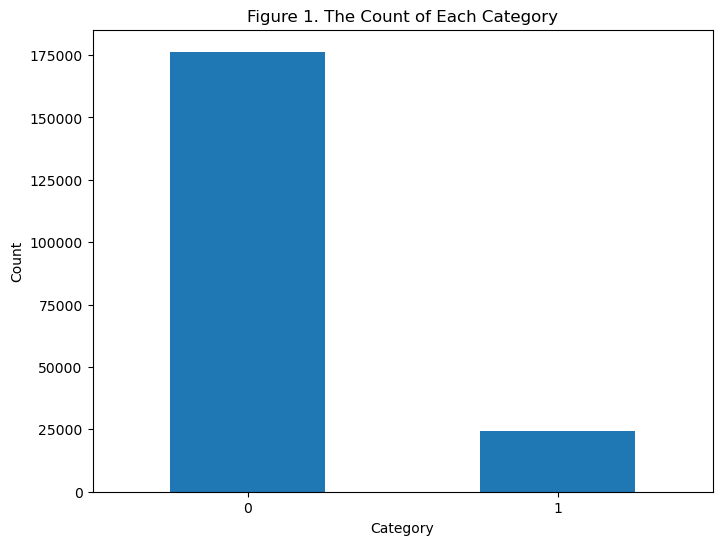

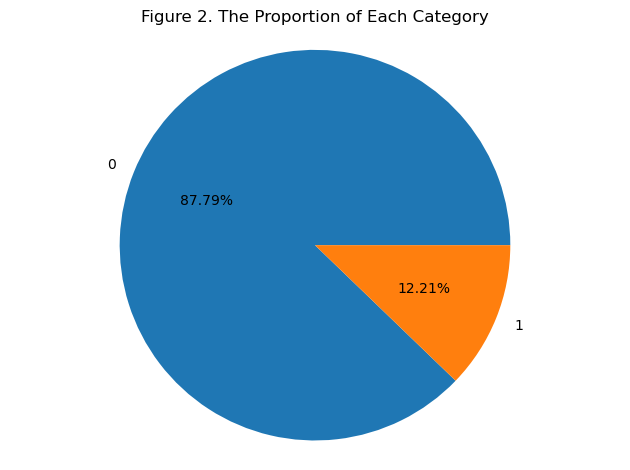

In [ ]:
import matplotlib.pyplot as plt
# plot the count of each category
fig, ax = plt.subplots(figsize=(8,6))
reviews['healthy_wellness'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel("Category")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Figure 1. The Count of Each Category")

# plot the proportion of each category
labels = reviews['healthy_wellness'].unique().tolist()
counts = reviews['healthy_wellness'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("Figure 2. The Proportion of Each Category")

plt.tight_layout()
plt.show()


With a proportion of 12.2% representing healthy wellness articles and 87.8% representing other articles, it is evident that our data is imbalanced. Therefore, it is necessary to create a new balanced dataset for model building.

### Balance the data

To create a balanced data set that includes all of the health living and wellness articles, set sample_amount to the total number of those articles (24,521).


In [ ]:
# use the full balanced document set which is determined by total number of healthy living and wellness articles
sample_amount =  len(reviews[reviews["healthy_wellness"] == 1]) 

print(sample_amount)

healthy_wellness = reviews[reviews['healthy_wellness'] == 1].sample(n=sample_amount)
not_healthy_wellness = reviews[reviews['healthy_wellness'] == 0].sample(n=sample_amount)

24521


In [ ]:
# create a balanced dataset
review_sample = pd.concat([healthy_wellness, not_healthy_wellness])

In [ ]:
# describe new dataset
review_sample.describe()

,healthy_wellness
count,49042.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


# Building and Training Models

Here, we will tune and train a predictor model for classifying healthy-living and wellness articles.

In [ ]:
target_names = ['NOT HEALTHY LIVING - WELLNESS','HEALTHY LIVING - WELLNESS']

### Model 1

---

For this project, we will utilize the "distilbert-base-uncased" transformer models, which is designed to process and understand text data by capturing contextual relationships between words. The "uncased" attribute indicates that the model has been trained on lowercased text, treating uppercase and lowercase letters as equivalent. With model 1, we will use the default parameters of the "distilbert-base-uncased" model, including a maximum feature count of 20,000 and a maximum sequence length of 512. Furthermore, the training process will be limited to a maximum of 6 epochs.

In [ ]:
# convert text data into features for distilbert model
train1, val1, preprocess1 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy_wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
174419                   0.0               1.0
180876                   0.0               1.0
165423                   0.0               1.0
166185                   0.0               1.0
54057                    0.0               1.0
['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
190323                   0.0               1.0
102588                   0.0               1.0
101550                   0.0               1.0
98935                    1.0               0.0
188815                   0.0               1.0


preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 67


In [ ]:
# load distilbert in a learner object
model1 = preprocess1.get_classifier()
learner1 = ktrain.get_learner(model1, train_data=train1, val_data=val1, batch_size=16)

In [ ]:
learner1.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
2758/2758 [==============================] - 1492s 534ms/step - loss: 0.4716 - accuracy: 0.8029
Epoch 2/6
2758/2758 [==============================] - 1484s 538ms/step - loss: 0.2367 - accuracy: 0.9075
Epoch 3/6
2758/2758 [==============================] - 1481s 537ms/step - loss: 0.3956 - accuracy: 0.7787
Epoch 4/6
2758/2758 [==============================] - 1481s 537ms/step - loss: 0.6943 - accuracy: 0.5026
Epoch 5/6
2758/2758 [==============================] - 1443s 523ms/step - loss: 336.9737 - accuracy: 0.5002


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


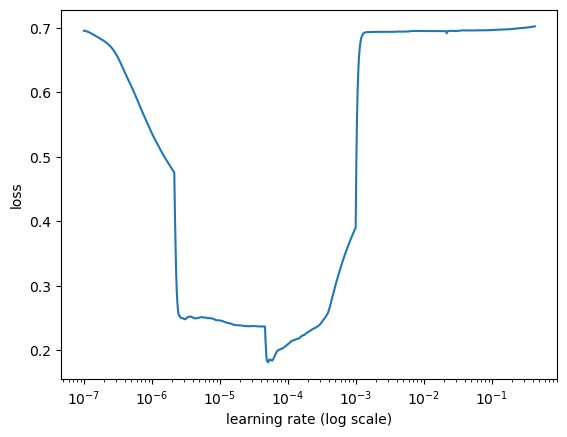

In [ ]:
# plot the learning rate
learner1.lr_plot()

We can observe that the classifier provides minimal loss when the learning rate is 1e-4. Now, we use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [ ]:
# train best model based on the tuned learner
history1=learner1.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
2759/2759 [==============================] - 1512s 545ms/step - loss: 0.1964 - accuracy: 0.9259 - val_loss: 0.2014 - val_accuracy: 0.9211
Epoch 2/10
2759/2759 [==============================] - 1496s 542ms/step - loss: 0.1293 - accuracy: 0.9545 - val_loss: 0.2315 - val_accuracy: 0.9170
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


### Get the predictor

In [ ]:
predictor1 = ktrain.get_predictor(learner1.model, preproc=preprocess1)

In [ ]:
#predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")

In [ ]:
validation1 = learner1.validate(val_data=val1, print_report=True)

154/154 [==============================] - 25s 151ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2474
           1       0.91      0.93      0.92      2431

    accuracy                           0.92      4905
   macro avg       0.92      0.92      0.92      4905
weighted avg       0.92      0.92      0.92      4905



---

### From the result above:

 1. precision for non healthy living - wellness articles: 0.93
 2. recall for non healthy living - wellness articles: 0.91
 3. precision for healthy living - wellness articles: 0.91
 4. recall for healthy living - wellness articles: 0.93
 5. overall accuracy: 0.92

 ---


# Tune parameter

## Model 2

Now, in order to save resources and reduce runtime, we will tune the previous model by decreasing max_feature to 10,000 and maxlen to 256. Let's evaluate how well the model performs with this configuration.

In [ ]:
# convert text data into features for distilbert model
train2, val2, preprocess2 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy_wellness"],
    val_df=None,
    max_features=10000,
    maxlen=256,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
139417                   0.0               1.0
29116                    0.0               1.0
143292                   0.0               1.0
120377                   1.0               0.0
107917                   0.0               1.0
['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
188463                   0.0               1.0
137701                   0.0               1.0
82157                    1.0               0.0
63470                    0.0               1.0
192111                   0.0               1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 33
	95percentile : 58
	99percentile : 69


In [ ]:
# load distilbert in a learner object
model2 = preprocess2.get_classifier()
learner2 = ktrain.get_learner(model2, train_data=train2, val_data=val2, batch_size=16)

In [ ]:
# find the optimal learning rate
learner2.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
2758/2758 [==============================] - 725s 256ms/step - loss: 0.4669 - accuracy: 0.8061
Epoch 2/6
2758/2758 [==============================] - 715s 259ms/step - loss: 0.2390 - accuracy: 0.9066
Epoch 3/6
2758/2758 [==============================] - 714s 259ms/step - loss: 0.4135 - accuracy: 0.7588
Epoch 4/6
2758/2758 [==============================] - 714s 259ms/step - loss: 0.7261 - accuracy: 0.5012
Epoch 5/6
2758/2758 [==============================] - 714s 259ms/step - loss: 0.7020 - accuracy: 0.4964
Epoch 6/6
2758/2758 [==============================] - 666s 242ms/step - loss: 0.8109 - accuracy: 0.4990


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


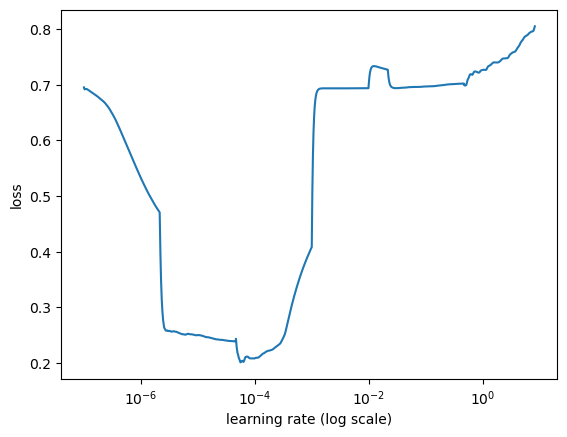

In [ ]:
# plot the learning rate
learner2.lr_plot()

In [ ]:
# train the best model based on the tuned learner
history2=learner2.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
2759/2759 [==============================] - 752s 266ms/step - loss: 0.2503 - accuracy: 0.9024 - val_loss: 0.1975 - val_accuracy: 0.9242
Epoch 2/10
2759/2759 [==============================] - 730s 265ms/step - loss: 0.1514 - accuracy: 0.9450 - val_loss: 0.2065 - val_accuracy: 0.9233
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


### Get the predictor

In [ ]:
predictor2 = ktrain.get_predictor(learner2.model, preproc=preprocess2)

In [ ]:
validation2 = learner2.validate(val_data=val2, print_report=True)

154/154 [==============================] - 23s 141ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2457
           1       0.91      0.94      0.93      2448

    accuracy                           0.92      4905
   macro avg       0.92      0.92      0.92      4905
weighted avg       0.92      0.92      0.92      4905



---

### From the result above:

 1. precision for non healthy living - wellness articles: 0.94
 2. recall for non healthy living - wellness articles: 0.91
 3. precision for healthy living - wellness articles: 0.91
 4. recall for healthy living - wellness articles: 0.94
 5. overall accuracy: 0.92

 ---


## Model 3

Now, I would like to try a new transformer model called "BERT" to see if it brings any improvements to the model's performance.

In [ ]:
# convert text data into features for bert model
train3, val3, preprocess3 = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy_wellness"],
    val_df=None,
    max_features=10000,
    maxlen=256,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="bert",
    verbose=1
)

['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
106888                   0.0               1.0
23777                    0.0               1.0
53805                    1.0               0.0
76773                    1.0               0.0
144582                   1.0               0.0
['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
32890                    1.0               0.0
169512                   0.0               1.0
21078                    1.0               0.0
153295                   0.0               1.0
188375                   1.0               0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
import random
random.seed(20191120) 

In [ ]:
# load bert in a learner object
model3 = ktrain.text.text_classifier("bert", train_data=train3, preproc=preprocess3)
learner3 = ktrain.get_learner(model3, train_data=train3, val_data=val3, batch_size=16)

Is Multi-Label? False
maxlen is 256
done.


In [ ]:
# find the optimal learning rate 
learner3.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
2759/2759 [==============================] - 2562s 911ms/step - loss: 0.4502 - accuracy: 0.7871
Epoch 2/6
2759/2759 [==============================] - 2512s 911ms/step - loss: 0.2285 - accuracy: 0.9105
Epoch 3/6
2759/2759 [==============================] - 2508s 909ms/step - loss: 0.4951 - accuracy: 0.6919
Epoch 4/6
2759/2759 [==============================] - 145s 52ms/step - loss: 0.7837 - accuracy: 0.5031


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


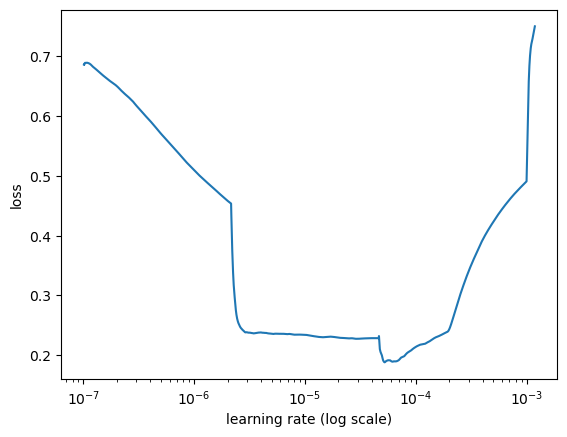

In [ ]:
# plot the learning rate
learner3.lr_plot()

We can observe that the classifier provides minimal loss when the learning rate is 1e-4. Now, we use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [ ]:
# train the best model based on the tuned learner
history3=learner3.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
2759/2759 [==============================] - 2627s 948ms/step - loss: 0.2507 - accuracy: 0.9002 - val_loss: 0.1969 - val_accuracy: 0.9231
Epoch 2/10
2759/2759 [==============================] - 2656s 963ms/step - loss: 0.1587 - accuracy: 0.9409 - val_loss: 0.2268 - val_accuracy: 0.9191
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


### Get the predictor

In [ ]:
predictor3 = ktrain.get_predictor(learner3.model, preproc=preprocess3)

In [ ]:
validation3 = learner3.validate(val_data=val3, print_report=True)

154/154 [==============================] - 95s 617ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2406
           1       0.91      0.94      0.93      2499

    accuracy                           0.92      4905
   macro avg       0.92      0.92      0.92      4905
weighted avg       0.92      0.92      0.92      4905



---

### From the result above:

 1. precision for non healthy living - wellness articles: 0.93
 2. recall for non healthy living - wellness articles: 0.91
 3. precision for healthy living - wellness articles: 0.91
 4. recall for healthy living - wellness articles: 0.94
 5. overall accuracy: 0.92

 ---

# Conclusion

The objective of this project is to classify articles as either related to healthy living or wellness. After comparing the performance of the three models discussed, we can conclude that:
  + these three models have the same overall accuracy of 92% and we can see that this number is larger than the accuracy of 86% in Dr. Vargo's Benchmarks.
  
  + model 2, which utilized the "distilbert-base-uncased" transformer model with a maximum feature count of 10,000 and a maximum sequence length of 256, achieved the highest precision of 94% for non-healthy living or wellness articles and highest recall of 94% for healthy living or wellness articles.

It's worth noting that due to limited resources and runtime constraints, the models were trained using a restricted approach. However, there are several potential avenues for improving model performance. For instance, experimenting with different transformer models and adjusting various parameters could yield better results. Exploring these alternatives could lead to enhanced classification capabilities and more accurate predictions.